<a href="https://colab.research.google.com/github/ayulockin/interpretabilitycnn/blob/master/GradCAM_W%26B_Way.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports, Installations and Setups

In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
%%capture
!pip install wandb

In [0]:
import wandb
from wandb.keras import WandbCallback

wandb.login()

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Successfully logged in to Weights & Biases!


In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import cv2

# Download Cat and Dog Dataset

In [0]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2020-04-21 08:33:36--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.212.128, 2607:f8b0:4001:c0d::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.212.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  27.2MB/s    in 2.4s    

2020-04-21 08:33:38 (27.2 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500


# Prepare Dataset

In [0]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=20, 
                                   horizontal_flip=True, 
                                   width_shift_range=0.1, 
                                   height_shift_range=0.1)

val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# Model

In [0]:
def catdogmodel():
  inputs = keras.layers.Input(shape=(150,150,3))
  x = keras.layers.Conv2D(32, (3,3), padding='valid')(inputs)
  x = keras.layers.BatchNormalization()(x)
  x = keras.activations.relu(x)
  x = keras.layers.Dropout(0.2)(x)
  x = keras.layers.MaxPooling2D(2)(x)

  x = keras.layers.Conv2D(64, (3,3), padding='valid')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.activations.relu(x)
  x = keras.layers.Dropout(0.2)(x)
  x = keras.layers.MaxPooling2D(2)(x)

  x = keras.layers.Conv2D(128, (3,3), padding='valid')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.activations.relu(x)
  x = keras.layers.Dropout(0.2)(x)
  x = keras.layers.MaxPooling2D(2)(x)

  x = keras.layers.Flatten()(x)
  x = keras.layers.Dropout(0.2)(x)
  x = keras.layers.Dense(512, activation='relu')(x)
  x = keras.layers.Dense(64, activation='relu')(x)
  outputs = keras.layers.Dense(1, activation='sigmoid')(x)

  return keras.models.Model(inputs, outputs)

In [0]:
keras.backend.clear_session()
model = catdogmodel()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 148, 148, 32)      128       
_________________________________________________________________
tf_op_layer_Relu (TensorFlow [(None, 148, 148, 32)]    0         
_________________________________________________________________
dropout (Dropout)            (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496 

# Compile

In [0]:
model.compile('adam', 'binary_crossentropy', ['acc'])

# W&B Init and Callback

In [0]:
## Reference: https://www.pyimagesearch.com/2020/03/09/grad-cam-visualize-class-activation-maps-with-keras-tensorflow-and-deep-learning/
class GradCAM:
  def __init__(self, model, layerName):
    self.model = model
    self.layerName = layerName
    
    self.gradModel = keras.models.Model(inputs=[self.model.inputs], 
                                        outputs=[self.model.get_layer(self.layerName).output, self.model.output])
    
  def compute_heatmap(self, image, classIdx, eps=1e-8):
    
    with tf.GradientTape() as tape:
      inputs = tf.cast(image, tf.float32)
      (convOutputs, predictions) = self.gradModel(inputs)
      if len(predictions)==1:
        # Binary Classification
        loss = predictions[0]
      else:
        loss = predictions[:, classIdx]
      
    grads = tape.gradient(loss, convOutputs)
    
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads
    
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]
    
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
    
    (w, h) = (image.shape[2], image.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))
    
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    heatmap = (heatmap * 255).astype("uint8")
    
    return heatmap
    
  def overlay_heatmap(self, heatmap, image, alpha=0.5, colormap=cv2.COLORMAP_VIRIDIS):
    heatmap = cv2.applyColorMap(heatmap, colormap)
    output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
    
    return (heatmap, output)

In [0]:
class GRADCamLogger(tf.keras.callbacks.Callback):
    def __init__(self, validation_data):
      super(GRADCamLogger, self).__init__()
      self.validation_data = validation_data

    def on_epoch_end(self, logs, epoch):
      images = []
      grad_cam = []

      ## Initialize GRADCam Class
      cam = GradCAM(model)

      for image in self.validation_data:
        image = np.expand_dims(image, 0)
        pred = model.predict(image)
        classIDx = np.argmax(pred[0])
  
        ## Compute Heatmap
        heatmap = cam.compute_heatmap(image, classIDx)
        
        image = image.reshape(image.shape[1:])
        image = image*255
        image = image.astype(np.uint8)

        ## Overlay heatmap on original image
        heatmap = cv2.resize(heatmap, (image.shape[0],image.shape[1]))
        (heatmap, output) = cam.overlay_heatmap(heatmap, image, alpha=0.5)

        images.append(image)
        grad_cam.append(output)

      wandb.log({"images": [wandb.Image(image)
                            for image in images]})
      wandb.log({"gradcam": [wandb.Image(cam)
                            for cam in grad_cam]})

In [0]:
## Prepare sample images to run your GradCam on. 
sample_images, sample_labels = validation_generator[1]
sample_images.shape, sample_labels.shape

((20, 150, 150, 3), (20,))

In [0]:
wandb.init(entity='ayush-thakur', project='gradcam-wandb')

W&B Run: https://app.wandb.ai/ayush-thakur/gradcam-wandb/runs/1u21sid8

# Train

In [0]:
history = model.fit(train_generator,
                    steps_per_epoch=300,
                    epochs=20,
                    validation_data=validation_generator,
                    validation_steps=50,
                    callbacks=[WandbCallback(data_type="image", validation_data=(sample_images, sample_labels), labels=["Cat", "Dog"]),
                               GRADCamLogger(sample_images)])

Epoch 1/20
300/300 [==============================] - 71s 236ms/step - loss: 1.2862 - acc: 0.6183 - val_loss: 0.6668 - val_acc: 0.5600
Epoch 2/20
300/300 [==============================] - 70s 232ms/step - loss: 0.6238 - acc: 0.6783 - val_loss: 0.5864 - val_acc: 0.6630
Epoch 3/20
300/300 [==============================] - 68s 228ms/step - loss: 0.5527 - acc: 0.7203 - val_loss: 0.6059 - val_acc: 0.6830
Epoch 4/20
300/300 [==============================] - 69s 231ms/step - loss: 0.5118 - acc: 0.7509 - val_loss: 0.6328 - val_acc: 0.6860
Epoch 5/20
300/300 [==============================] - 69s 231ms/step - loss: 0.4770 - acc: 0.7683 - val_loss: 0.5130 - val_acc: 0.7420
Epoch 6/20
300/300 [==============================] - 68s 228ms/step - loss: 0.4423 - acc: 0.7956 - val_loss: 0.4961 - val_acc: 0.7730
Epoch 7/20
300/300 [==============================] - 68s 227ms/step - loss: 0.4260 - acc: 0.8004 - val_loss: 0.5465 - val_acc: 0.7020
Epoch 8/20
300/300 [==============================] - 6

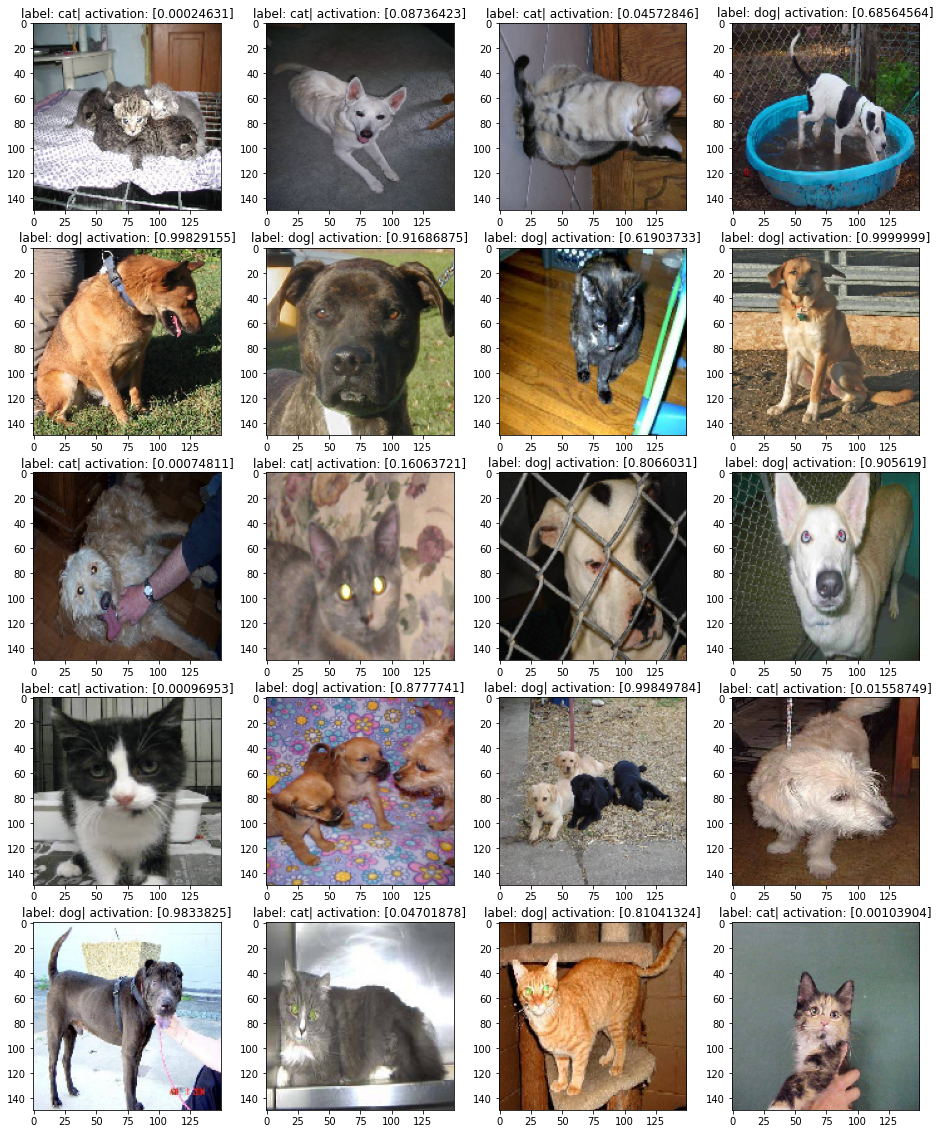

In [0]:
n_rows=len(sample_images)//4
n_cols=4 

fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(16, 4*n_rows))

c = 0
for i in range(n_rows):
  for j in range(n_cols):
    image = np.expand_dims(sample_images[c], 0)
    pred = model.predict(image)
    if pred[0]>0.5:
      label='dog'
    else:
      label='cat'

    axs[i][j].imshow(sample_images[c]);
    axs[i][j].set_title('label: {}| activation: {}'.format(label, pred[0]));
    c+=1